# Compute PMF of butane dihedral with umbrella sampling and FastMBAR

In [47]:
## import required packages
import os, math, sys
import numpy as np
import matplotlib.pyplot as plt
import simtk.openmm.app  as omm_app
import simtk.openmm as omm
import simtk.unit as unit
from tqdm import tqdm
import mdtraj
from FastMBAR import *

**NOTE:** The following commands use relative directory pathees and assume that the current working directory is FastMBAR/examples/butane. Therefore, the current working directory has to be changed into FastMBAR/example/butane before running the following commands.

In [16]:
## change the working directory into ./examples/butane
#os.chdir("./butane")
print("current working directory: {}".format(os.getcwd()))
assert os.getcwd()[-7:] == "/butane", ( 
       f"Error: your current working directory is {os.getcwd()}!"
        "You need to change working directory to ./examples/butane."
       )

current working directory: /Users/dingxq/Google Drive/ProjectsOnGitHub/FastMBAR/examples/butane


## 1. Construct an OpenMM system of butane
Because we are using OpenMM as our MD engine, we need to setup the
MD molecular system in the format required by OpenMM. The format/object
used by OpenMM for a molecular system happens to be a class called [System](http://docs.openmm.org/latest/api-python/generated/simtk.openmm.openmm.System.html#simtk.openmm.openmm.System).
Therefore, we will prepare our MD molecular system as an OpenMM System.
When we prepare the OpenMM system, we add a [CustomTorsionForce](http://docs.openmm.org/latest/api-python/generated/simtk.openmm.openmm.CustomTorsionForce.html#simtk.openmm.openmm.CustomTorsionForce) so
that we can add biasing potentials to the system in the following umbrella
sampling.

Read **psf** and **pdb** files of butane: butane.psf and butane.pdb.
The psf file, butane.psf, contains topolgy of butane and it is the topolgy file format used by CHARMM.
The psf file, butane.psf, used here is generated using CHARMM.
In your study, you usually alreay have a pdb file of your system. 
You can generate the topology file of your system using various MD softwares such as CHARMM, Gromacs and Amber among others. Just note that different softwares use different format for topology files and OpenMM has 
several parser for topology files with different foramt.

In [27]:
psf = omm_app.CharmmPsfFile('./data/butane.psf')
pdb = omm_app.PDBFile('./data/butane.pdb')

Read CHARMM force field for butane. The CHARMM force field is downloaded from [here](http://mackerell.umaryland.edu/charmm_ff.shtml)

In [28]:
params = omm_app.CharmmParameterSet('./data/top_all35_ethers.rtf',
                                    './data/par_all35_ethers.prm')

Create a OpenMM system based on the psf file of butane and the CHARMM force field.
Then a harmonic biasing potential for butane dihedral (3-6-9-13)is added to the system so that we can use the biasing potential in the following umbrella sampling.
Adding a biasing potential to a system is very easy in OpenMM. 
We don't have to change any source code of OpenMM. All we need to do is to tell OpenMM the formula of the biasing potential and degree of freedome we want to add the biasing potential to.

In [20]:
## creay an OpenMM system
system = psf.createSystem(params, nonbondedMethod=omm_app.NoCutoff)

## add a harmonic biasing potential on butane dihedral to the OpenMM system
bias_torsion = omm.CustomTorsionForce("0.5*K*dtheta^2; dtheta = min(diff, 2*Pi-diff); diff = abs(theta - theta0)")
bias_torsion.addGlobalParameter("Pi", math.pi)
bias_torsion.addGlobalParameter("K", 1.0)
bias_torsion.addGlobalParameter("theta0", 0.0)
## 3, 6, 9, 13 are indices of the four carton atoms in butane, between which
## the dihedral angle is biased.
bias_torsion.addTorsion(3, 6, 9, 13)
system.addForce(bias_torsion)

8

After constructing the OpenMM system of butane, we can save it in an XML formated text file, which can be used later for simulations. Therefore, if we want to use the same system in another script, we can just read the text file in an OpenMM system instead of constructing it again.
You can even open the XML formated text file using a text editor and see what information about the system is included in the XML file.

In [21]:
## save the OpenMM system of butane
with open("./output/system.xml", 'w') as file_handle:
    file_handle.write(omm.XmlSerializer.serialize(system))

## 2. Run umbrella sampling
We run umbrella sampling for the butane dihedral (atom indices: 3-6-9-13).
The dihedral is split into multiple windows and in each window, the dihedral
is restrainted around a center using a harmonic biasing potential. In this
script, we run simulations in each window sequentially, but they can be run in
parallel if you have a computer cluster with multiple nodes.

In [22]:
## read the OpenMM system of butane
with open("./output/system.xml", 'r') as file_handle:
    xml = file_handle.read()
system = omm.XmlSerializer.deserialize(xml)

## read psf and pdb file of butane
psf = omm_app.CharmmPsfFile("./data/butane.psf")
pdb = omm_app.PDBFile('./data/butane.pdb')

In order to run simulations in OpenMM, we need to construct an OpenMM context, which consists of a system, an integrator and a platform.
The system is just the butane system we have constructed above.
The integrator specifies what kind integration method we should use. Here, we will use Langevin dynamics for NVP ensemble simulation, which corresponds to the OpenMM.LangevinIntegrator.
The platform specifies what kind of hardware we will run simulation on. Here, we choose to use CPUs because the size of the system is quite small.

In [31]:
#### setup an OpenMM context

## platform
platform = omm.Platform.getPlatformByName('CPU')

## intergrator
T = 298.15 * unit.kelvin  ## temperature
fricCoef = 10/unit.picoseconds ## friction coefficient 
stepsize = 1 * unit.femtoseconds ## integration step size
integrator = omm.LangevinIntegrator(T, fricCoef, stepsize)

## construct an OpenMM context
context = omm.Context(system, integrator, platform)

Here we set the force constant and centers for the harmonic biasing potentials on butane dihedral.

In [34]:
## set force constant K for the biasing potential. 
## the unit here is kJ*mol^{-1}*nm^{-2}, which is the default unit used in OpenMM
K = 100
context.setParameter("K", K)

## M centers of harmonic biasing potentials
M = 5
theta0 = np.linspace(-math.pi, math.pi, M, endpoint = False)
np.savetxt("./output/theta0.csv", theta0, delimiter = ",")

The following loop is used to run umbrella sampling window by window.
In each iteration, we first set the center of the harmonic biasing potential.
Then the configuration of butane is minimized and equilibrated with the biasing potential.
After initial equilibration, configurations are sampled and saved.

In [35]:
## the main loop to run umbrella sampling window by window
for theta0_index in range(M):
    print(f"sampling at theta0 index: {theta0_index} out of {M}")

    ## set the center of the biasing potential
    context.setParameter("theta0", theta0[theta0_index])

    ## minimize
    context.setPositions(pdb.positions)
    state = context.getState(getEnergy = True)
    energy = state.getPotentialEnergy()
    for i in range(50):
        omm.LocalEnergyMinimizer_minimize(context, 1, 20)
        state = context.getState(getEnergy = True)
        energy = state.getPotentialEnergy()

    ## initial equilibrium
    integrator.step(5000)

    ## sampling production. trajectories are saved in dcd files
    file_handle = open(f"./output/traj/traj_{theta0_index}.dcd", 'bw')
    dcd_file = omm_app.dcdfile.DCDFile(file_handle, psf.topology, dt = stepsize)
    for i in tqdm(range(1000)):
        integrator.step(100)
        state = context.getState(getPositions = True)
        positions = state.getPositions()
        dcd_file.writeModel(positions)
    file_handle.close()

sampling at theta0 index: 0 out of 5


100%|██████████| 1000/1000 [00:21<00:00, 47.27it/s]


sampling at theta0 index: 1 out of 5


100%|██████████| 1000/1000 [00:21<00:00, 46.53it/s]


sampling at theta0 index: 2 out of 5


100%|██████████| 1000/1000 [00:21<00:00, 47.05it/s]


sampling at theta0 index: 3 out of 5


100%|██████████| 1000/1000 [00:21<00:00, 47.19it/s]


sampling at theta0 index: 4 out of 5


100%|██████████| 1000/1000 [00:21<00:00, 47.22it/s]


## 3. Compute and collect the butane dihedral values
For configurations in trajectories sampled using umbrella sampling, we compute the butane dihedral and
save them in csv files. The dihedral is between four atoms with indices of 3, 6, 9, and 13. 
Here we use the Python package mdtraj to compute dihedrals.

In [43]:
topology = mdtraj.load_psf("./data/butane.psf")
for theta0_index in range(M):
    traj = mdtraj.load_dcd(f"./output/traj/traj_{theta0_index}.dcd", topology)
    theta = mdtraj.compute_dihedrals(traj, [[3, 6, 9, 13]])
    np.savetxt(f"./output/dihedral/dihedral_{theta0_index}.csv", theta, fmt = "%.5f", delimiter = ",")

## 4. Use FastMBAR to solve MBAR/UWHAM equations and compute the PMF

In [45]:
thetas = []
num_conf = []
for theta0_index in range(M):
    theta = np.loadtxt(f"./output/dihedral/dihedral_{theta0_index}.csv", delimiter = ",")
    thetas.append(theta)
    num_conf.append(len(theta))
thetas = np.concatenate(thetas)
num_conf = np.array(num_conf).astype(np.float64)
N = len(thetas)

reduced_energy_matrix = np.zeros((M, N))
K = 100
T = 298.15 * unit.kelvin
kbT = unit.BOLTZMANN_CONSTANT_kB * 298.15 * unit.kelvin * unit.AVOGADRO_CONSTANT_NA
kbT = kbT.value_in_unit(unit.kilojoule_per_mole)

theta0 = np.loadtxt("./output/theta0.csv", delimiter = ",")

for theta0_index in range(M):
    current_theta0 = theta0[theta0_index]
    diff = np.abs(thetas - current_theta0)
    diff = np.minimum(diff, 2*math.pi-diff)
    reduced_energy_matrix[theta0_index, :] = 0.5*K*diff**2/kbT

fastmbar = FastMBAR(energy = reduced_energy_matrix, num_conf = num_conf, cuda=False, verbose = True)
#print(fastmbar.F)

solve MBAR equation using CPU


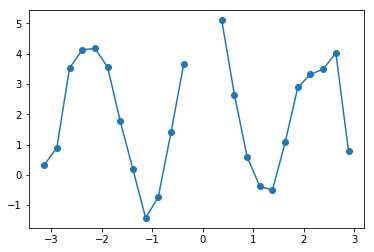

In [49]:
M_PMF = 25
theta_PMF = np.linspace(-math.pi, math.pi, M_PMF, endpoint = False)
width = 2*math.pi / M_PMF
reduced_energy_PMF = np.zeros((M_PMF, N))

for i in range(M_PMF):
    theta_center = theta_PMF[i]
    theta_low = theta_center - 0.5*width
    theta_high = theta_center + 0.5*width

    indicator = ((thetas > theta_low) & (thetas <= theta_high)) | \
                 ((thetas + 2*math.pi > theta_low) & (thetas + 2*math.pi <= theta_high)) | \
                 ((thetas - 2*math.pi > theta_low) & (thetas - 2*math.pi <= theta_high))

    reduced_energy_PMF[i, ~indicator] = np.inf

PMF, _ = fastmbar.calculate_free_energies_of_perturbed_states(reduced_energy_PMF)

fig = plt.figure(0)
fig.clf()
plt.plot(theta_PMF, PMF, '-o')
plt.savefig("./output/PMF_fast_mbar.pdf")